In [11]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
featurefolder = 'ressummaryfeaturesxgbv6Norbits10000.0Nout1000/'
features = ['C_AMDnear', 'C_AMDfar', 'C_AMDouter']

In [13]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

In [14]:
trainX.shape

(7999, 3)

In [15]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [16]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.7163157199999999                                  
ERROR                                               
0.011851791637746602                                
HOLDOUT SCORE                                       
0.7431501078778036                                  
SCORE:                                                                        
0.7062761999999999                                                            
ERROR                                                                         
0.011822564906062446                                                          
HOLDOUT SCORE                                                                 
0.7357500579613565                                                            
SCORE:                                                                        
0.6638760400000001                                                            
ERROR                                             

0.013031997085930813                                                           
HOLDOUT SCORE                                                                  
0.7527216499286093                                                             
SCORE:                                                                         
0.5                                                                            
ERROR                                                                          
0.0                                                                            
HOLDOUT SCORE                                                                  
0.5                                                                            
SCORE:                                                                         
0.70644482                                                                     
ERROR                                                                          
0.012820999351779694                    

In [17]:
best

{'x_learning_rate': 0.1979046153788968,
 'x_max_depth': 4,
 'x_min_child': 7.0,
 'x_pos_weight': 8.230776548478934,
 'x_subsample': 0.9478275232396036,
 'x_tree_colsample': 0.6693977405547573}

In [18]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.695693+0.00673744	test-auc:0.682161+0.00990461
[1]	train-auc:0.737265+0.00551105	test-auc:0.71328+0.013171
[2]	train-auc:0.740967+0.00624637	test-auc:0.717671+0.0133423
[3]	train-auc:0.74835+0.00804464	test-auc:0.724421+0.01463
[4]	train-auc:0.750421+0.00886184	test-auc:0.724788+0.0130494
[5]	train-auc:0.755567+0.00539431	test-auc:0.727379+0.0137615
[6]	train-auc:0.758572+0.0050242	test-auc:0.726899+0.0145404
[7]	train-auc:0.760233+0.0047463	test-auc:0.727279+0.0131202
[8]	train-auc:0.7616+0.00525846	test-auc:0.726935+0.0124289
[9]	train-auc:0.764092+0.00369298	test-auc:0.728306+0.0145335
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.695693       0.006737       0.682161      0.009905
1        0.737265       0.005511       0.713280      0.013171
2        0.740967       0.006246       0.717671      0.013342
3        0.748350       0.008045       0.724421      0.014630
4        0.750421       0.008862       0.724788      0.013049
5        0.75556

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [19]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.6693977405547573, gamma=0,
              learning_rate=0.1979046153788968, max_delta_step=0, max_depth=4,
              min_child_weight=7.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=8.230776548478934,
              seed=None, silent=True, subsample=0.9478275232396036)

In [20]:
dill.dump([model, features, featurefolder], open(datapath+"../models/AMD_resonant.pkl", "wb"))

Text(0.5, 1.0, 'ROC curve (AUC = 0.754)')

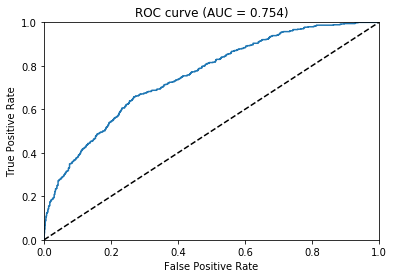

In [21]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features, filter=False)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [22]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features, filter=False)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.12325514107942581, recall = 1.0, precision = 0.2833944473546359
Threshold 0.1346980184316635, recall = 0.9963031423290203, precision = 0.2845828933474129
Threshold 0.14809627830982208, recall = 0.9944547134935305, precision = 0.2863225119744545
Threshold 0.1631324738264084, recall = 0.9944547134935305, precision = 0.2886266094420601
Threshold 0.17933502793312073, recall = 0.9944547134935305, precision = 0.29128316188413644
Threshold 0.18931174278259277, recall = 0.9926062846580407, precision = 0.2931222707423581
Threshold 0.19994547963142395, recall = 0.988909426987061, precision = 0.29444138690148597
Threshold 0.2161116898059845, recall = 0.988909426987061, precision = 0.2968923418423973
Threshold 0.23113195598125458, recall = 0.9870609981515711, precision = 0.29882484611080024
Threshold 0.24911563098430634, recall = 0.9870609981515711, precision = 0.3013544018058691
Threshold 0.26543137431144714, recall = 0.9870609981515711, precision = 0.3039271485486625
Threshold 0.2800

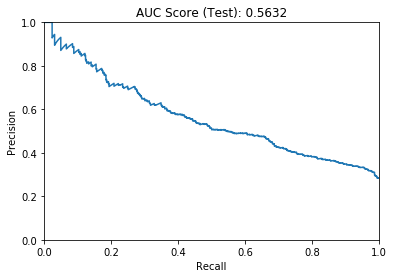

In [23]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 25.3)

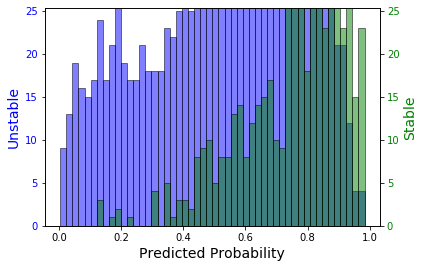

In [24]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features, filter=False)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,1.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

../modelfitting.py:71: RuntimeWarning: divide by zero encountered in true_divide
  errorbars.append(np.sqrt(1./nstable + 1./hist[i])*fracstable[-1]) # assume poisson counting errors for each fractional error, and add in quadrature for error on ratio.
../modelfitting.py:71: RuntimeWarning: invalid value encountered in double_scalars
  errorbars.append(np.sqrt(1./nstable + 1./hist[i])*fracstable[-1]) # assume poisson counting errors for each fractional error, and add in quadrature for error on ratio.


Text(0, 0.5, 'Fraction actually stable')

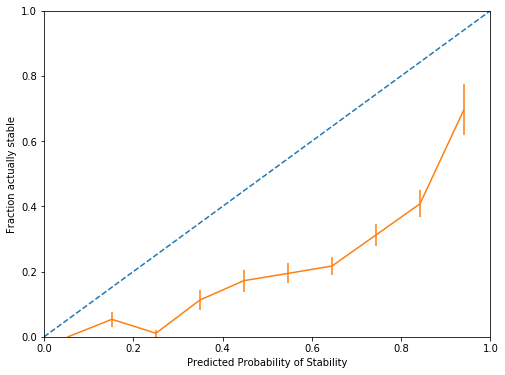

In [25]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10, filter=False)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

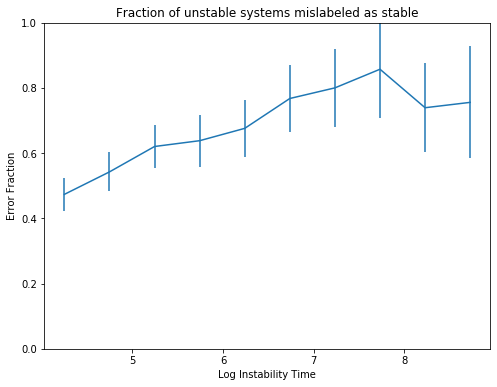

In [26]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10, filter=False)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

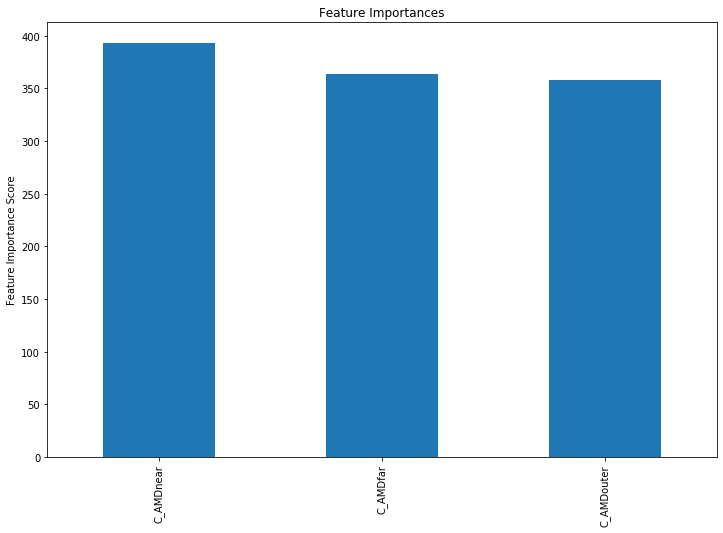

In [27]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# slice data between ranges of instability times

# slice data between ranges of instability times

# things that are just unstable might be very similar to things that are just stable

# predict at half a billion, then repredict at half a billion whether you'll be unstable at a billion

# do the summary features change with time?

# try training on just unstable systems